In [1]:
using PyPlot
using JuLIP
using JuLIP.ASE, JuLIP.Potentials, JuLIP.Constraints 
reload("MaterialsScienceTools")

In [2]:
"a fully equilibrated SW potential"
function sw_eq()
    T(σ, at) = trace(stress(StillingerWeber(σ=σ), at))
    at = JuLIP.ASE.bulk("Si", pbc=true)
    r0 = 2.0951
    r1 = r0 - 0.1 
    s0, s1 = T(r0, at), T(r1, at)
    while (abs(s1) > 1e-8) && abs(r0 - r1) > 1e-8
        rnew = (r0 * s1 - r1 * s0) / (s1 - s0)
        r0, r1 = r1, rnew
        s0, s1 = s1, T(rnew, at)
    end
    return StillingerWeber(σ=r1)
end 

# # quick test code to confirm that sw_eq() really produces a stress free state with no internal forces
# V = sw_eq()
# at = JuLIP.ASE.bulk("Si", cubic=true, pbc=true)
# @show vecnorm(stress(V, at), Inf), maximum(norm.(forces(V, at)))


sw_eq

In [3]:
reload("MaterialsScienceTools")

function si_plane(R)
    @assert isodd(R)
    atu, b, xcore, a = MaterialsScienceTools.Dislocations_Silicon_hard_110.fcc_edge_plane("Si")
    xcore = [0.0, 0.625 * a, 0.0]
    at = atu * (R, R, 1)
    set_pbc!(at, (false, false, true))
    b = b[1] 
    X = positions(at) |> mat 
    X = vecs(X)
    xcore = X[length(X) ÷ 2+1] + xcore
    return at, b, xcore 
end 

function layers(at)
    X = positions(at) |> mat
    x, y, z = X[1,:], X[2,:], X[3,:] 
    I0 = find(z .== 0)
    I1 = find(z .> 0)
    return [x[I0]'; y[I0]'], [x[I1]'; y[I1]']
end 

function plot_layers(at, x0=nothing)
    X0, X1 = layers(at)
    plot(X0[1,:], X0[2,:], "b.", markersize=8)
    plot(X1[1,:], X1[2,:], "g.", markersize=8)
    if x0 != nothing 
        plot([x0[1]], [x0[2]], "r.", markersize=10)
    end 
end 


function ulin_edge_isotropic(X, b, ν)
    x, y = X[1,:], X[2,:]
    r² = x.^2 + y.^2
    ux = b/(2*π) * ( angle(x + im*y) + (x .* y) ./ (2*(1-ν) * r²) )
    uy = -b/(2*π) * ( (1-2*ν)/(4*(1-ν)) * log(r²) + - 2 * y.^2 ./ (4*(1-ν) * r²) )
    return [ux'; uy']
end

function si_edge(R) 
    at, b, xcore = si_plane(R)
    X = positions(at) |> mat
    X2d = X[1:2,:] .- xcore[1:2]
    U = ulin_edge_isotropic(X2d, b, 0.25)
    X[1:2, :] += U
    set_positions!(at, vecs(X))
    return at, JVecF(xcore)
end 

dists(at, x0) = [norm(x - x0) for x in positions(at)]


dists (generic function with 1 method)

In [4]:
# at, b, x0 = si_plane(9)
# plot_layers(at, x0)

In [5]:
# at, x0 = si_edge(9)
# plot_layers(at, x0)

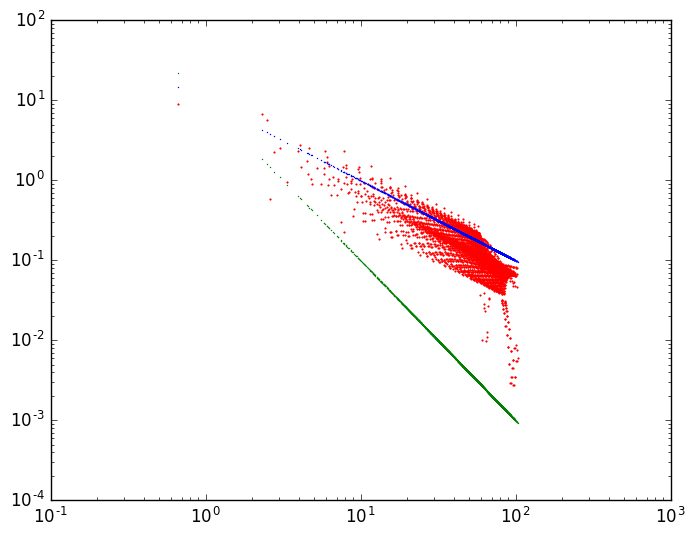

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32d76a490>
 PyObject <matplotlib.lines.Line2D object at 0x32d99e210>

In [6]:
at, x0 = si_edge(31)
calc = sw_eq()
f = norm.(forces(calc, at))
r = dists(at, x0)
loglog(r, f, "r.", markersize=2)
loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)

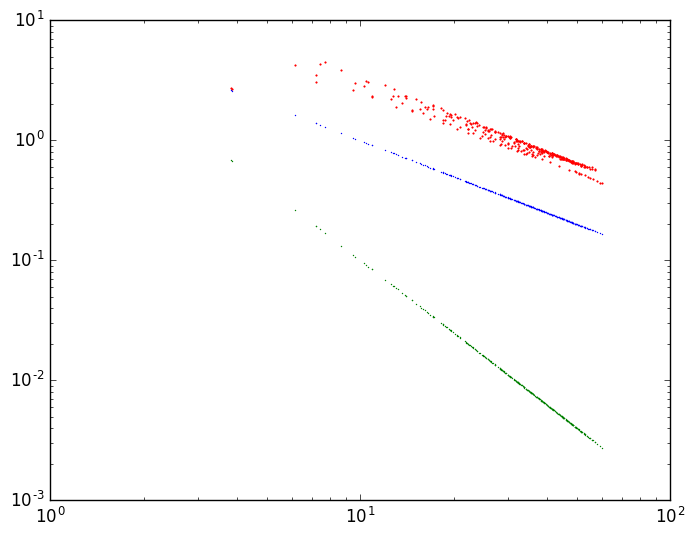

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32dbeec90>
 PyObject <matplotlib.lines.Line2D object at 0x32dd0e490>

In [7]:
at, _, _ = si_plane(9)
x0 = JVecF([-2.0, -2.0, 0.0])
X = [ x + (x-x0)/norm(x-x0) for x in positions(at)]
set_positions!(at, X)
f = norm.(forces(calc, at))
r = dists(at, x0)
loglog(r, f, "r.", markersize=2)
loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)


length(I0) = 0
Results of Optimization Algorithm


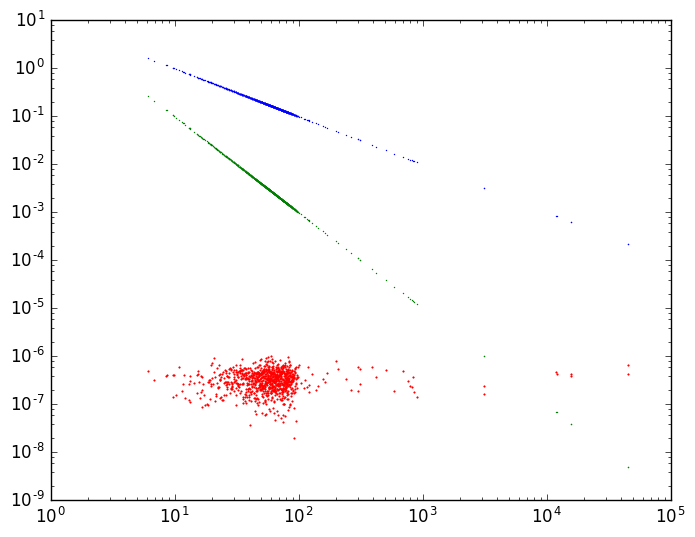

 * Algorithm: Conjugate Gradient
 * Starting Point: [1.414213562373095,1.414213562373095, ...]
 * Minimizer: [9.390749877306584,0.48306228571138743, ...]
 * Minimum: -3.741012e+03
 * Iterations: 496
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-06: true
   * f(x) > f(x'): false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 1512
 * Gradient Calls: 1016


2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32eca5a10>
 PyObject <matplotlib.lines.Line2D object at 0x325703b10>

In [10]:
at, _, _ = si_plane(15)
set_pbc!(at, true)
x0 = JVecF([-2.0, -2.0, 0.0])
for (i, x) in enumerate(positions(at))
    u = JVecF([x[1] - x0[1], x[2]-x0[2], 0.0]) / norm(x-x0) 
    X[i] += u
end 
set_positions!(at, X)
I0 = find(X[3,:] .== 0)
@show length(I0)
set_calculator!(at, calc)
set_constraint!(at, FixedCell(at, clamp = I0))
minimise!(at)
f = norm.(forces(calc, at))
r = dists(at, x0)
loglog(r, f, "r.", markersize=2)
loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)


In [11]:
function si_edge_outside(R) 
    at, b, xcore = si_plane(R)
    X = positions(at) |> mat
    X2d = X[1:2,:] .+ [2.0, 2.0]
    U = ulin_edge_isotropic(X2d, b, 0.25)
    X[1:2, :] += U
    set_positions!(at, vecs(X))
    return at, JVecF([2.0, 2.0, 0.0])
end 


si_edge_outside (generic function with 1 method)

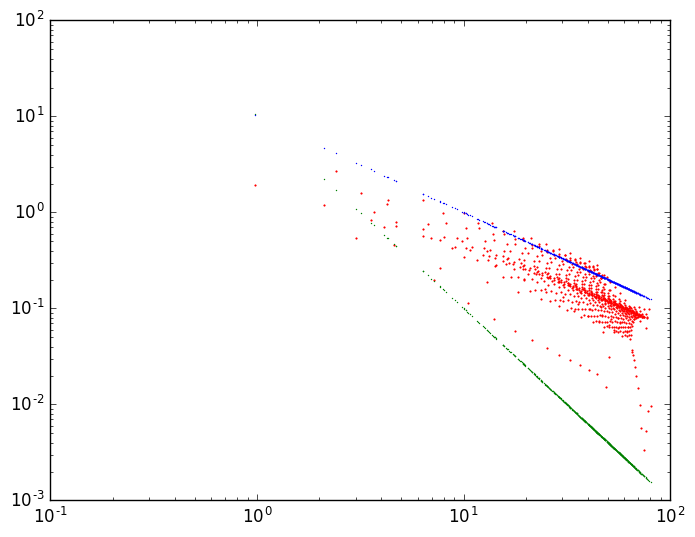

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32f161110>
 PyObject <matplotlib.lines.Line2D object at 0x32f32be50>

In [12]:
at, x0 = si_edge_outside(13) 
f = norm.(forces(calc, at))
r = dists(at, x0)
loglog(r, f, "r.", markersize=2)
loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)

In [6]:
using JuLIP, JuLIP.ASE, JuLIP.Potentials

"a fully equilibrated SW potential"
function sw_eq()
    T(σ, at) = trace(stress(StillingerWeber(σ=σ), at))
    at = JuLIP.ASE.bulk("Si", pbc=true)
    r0 = 2.0951
    r1 = r0 - 0.1 
    s0, s1 = T(r0, at), T(r1, at)
    while (abs(s1) > 1e-8) && abs(r0 - r1) > 1e-8
        rnew = (r0 * s1 - r1 * s0) / (s1 - s0)
        r0, r1 = r1, rnew
        s0, s1 = s1, T(rnew, at)
    end
    return StillingerWeber(σ=r1)
end 


function DpWcb(F, p, at = bulk("Si", pbc=true), sw = sw_eq())
    set_defm!(at, F)
    X = positions(at)
    X[2] = X[1] + p
    set_positions!(at, X)
    return -forces(sw, at)[2]
end


function DpDpWcb()
    at = bulk("Si", pbc=true)
    sw = sw_eq()
    F0 = defm(at)
    p0 = positions(at)[2] |> Vector
    h = 1e-5
    DpDpW = zeros(3, 3)
    for i = 1:3 
        p0[i] += h 
        DpW1 = DpWcb(F0, JVecF(p0), at, sw)
        p0[i] -= 2*h 
        DpW2 = DpWcb(F0, JVecF(p0), at, sw)
        p0[i] += h
        DpDpW[:, i] = (DpW1 - DpW2) / (2*h)
    end 
    return 0.5 * (DpDpW + DpDpW')
end


type WcbQuad
    DpDpW::Matrix{Float64}
    DpDpW_inv::Matrix{Float64}
    at::AbstractAtoms
end

function WcbQuad()
    DpDpW = DpDpWcb()
    return WcbQuad(DpDpW, pinv(DpDpW), bulk("Si", pbc=true))
end 

function (W::WcbQuad)(F)
    p0 = positions(W.at)[2]
    p1 = p0 - W.DpDpW_inv * DpWcb(F, p0, W.at)
    p2 = p1 - W.DpDpW_inv * DpWcb(F, p1, W.at)
    return p1
end

at = bulk("Si", cubic=false, pbc = true)
sw = sw_eq()
@show maxnorm(forces(sw, at))
F = defm(at)
G = rand(JMatF)
for p = 2:6
    h = 0.1^p 
    set_defm!(at, F + h * G, updatepositions=true)
    @show maxnorm(forces(sw, at))
end 
    ;

maxnorm(forces(sw,at)) = 0.0
maxnorm(forces(sw,at)) = 0.08882263133196105
maxnorm(forces(sw,at)) = 0.008900663902462629
maxnorm(forces(sw,at)) = 0.000890255623159234
maxnorm(forces(sw,at)) = 8.902745990882584e-5
maxnorm(forces(sw,at)) = 8.90276497136973e-6


In [7]:
at = bulk("Si", cubic=false, pbc = true)
sw = sw_eq()
@show maxnorm(forces(sw, at))
F0 = defm(at)
G = rand(JMatF)
W = WcbQuad()
for q = 2:6
    h = 0.1^q
    F = F0 + h * G
    ph = W(F)
    @show ph
    set_defm!(at, F, updatepositions=false)
    X = positions(at)
    X[2] = ph 
    set_positions!(at, X)
    @show maxnorm(forces(sw, at))
end 
;

maxnorm(forces(sw,at)) = 0.0
ph = [1.35943,1.35747,1.36176]
maxnorm(forces(sw,at)) = 0.00037053882034972945
ph = [1.35769,1.35751,1.35793]
maxnorm(forces(sw,at)) = 0.00020479284421751588
ph = [1.35752,1.3575,1.35754]
maxnorm(forces(sw,at)) = 2.0674005701911767e-6
ph = [1.3575,1.3575,1.3575]
maxnorm(forces(sw,at)) = 2.0487041890567896e-8
ph = [1.3575,1.3575,1.3575]
maxnorm(forces(sw,at)) = 2.0464166291999335e-10
